Definition of Data Science Problem

The purpose of this project is to build a model that will predict annual premium for vehicle insurance. Insurance companies are strugling greatly with proposing a premium charge that will cover the risk profile of customers and benefit their business. If this is not done properly, insurance company is at risk of paying more for customers' claims than actually gaining through annual premiums. This model will be used to provide guidance for insurance company's annual premium suggestions strategy.

Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from library.sb_utils import save_file

ModuleNotFoundError: No module named 'library'

Load the Insurance Data

In [2]:
ins_data=pd.read_csv('C:/Users/User/Desktop/Data Science Course/Capstone 2/trainInsurance.csv')

In [3]:
ins_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


There is a column Annual_Premium that we want to model on, whereas other columns are potential features which we will further explore to see if all are relevant for the model.

In [4]:
ins_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


Let's see if there are any missing values in the dataset.

In [5]:
missing = pd.concat([ins_data.isnull().sum(), 100 * ins_data.isnull().mean()], axis=1)
missing.columns=["count", "%"]
missing.sort_values(by=["count"], ascending=False)

,count,%
id,0,0.0
Gender,0,0.0
Age,0,0.0
Driving_License,0,0.0
Region_Code,0,0.0
Previously_Insured,0,0.0
Vehicle_Age,0,0.0
Vehicle_Damage,0,0.0
Annual_Premium,0,0.0
Policy_Sales_Channel,0,0.0


These are great news! There are no missing values in the dataset, so we will be able to use all observations in our model.

Exploring the data
Let's see how representative the data is and whether it covers wide range of possible options. First, we want to understand what is the age range included and whether it is egually represented. We will do this using describe method to see min, max and mean values. Next, it would be good to check Gender, Driving_Licence and Region_Code features. 

In [6]:
ins_data['Age'].describe()

count    381109.000000
mean         38.822584
std          15.511611
min          20.000000
25%          25.000000
50%          36.000000
75%          49.000000
max          85.000000
Name: Age, dtype: float64

Good, we can see that the age is widely represented. It goes from 20 to even 85 years, with a mean value of around 39 years. The question we can ask for later exploration is:
    - How many customers we have over 75 years and does it make sense to include them in the prediction model? Are they our target group for vehicle insurance?

In order to use Gender variable in the modelling process, it would be good to transform it to numerical values using 0 for Male and 1 for Female. We will do the same for Vehicle_Damage, where 0 will be No and 1 Yes.

In [7]:
ins_data['Gender'].replace(['Male','Female'],[0,1],inplace=True)
ins_data['Vehicle_Damage'].replace(['No', 'Yes'], [0,1], inplace=True)

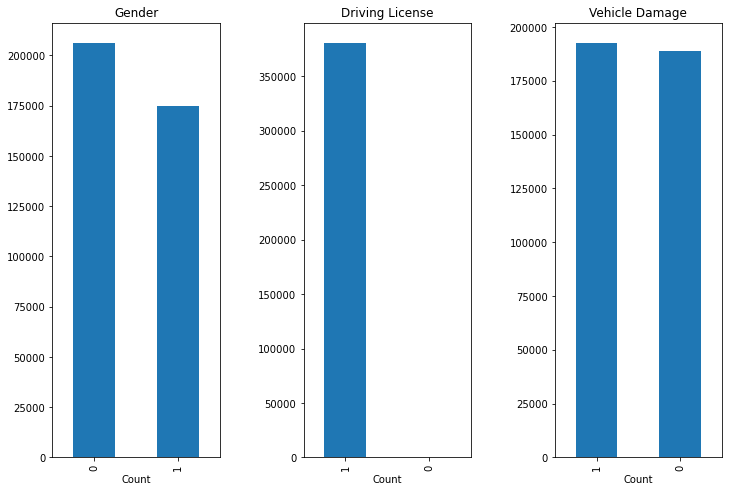

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ins_data.Gender.value_counts().plot(kind="bar", ax=ax[0])
ax[0].set_title("Gender")
ax[0].set_xlabel("Count")
ins_data.Driving_License.value_counts().plot(kind="bar", ax=ax[1])
ax[1].set_title("Driving License")
ax[1].set_xlabel("Count")
ins_data.Vehicle_Damage.value_counts().plot(kind="bar", ax=ax[2])
ax[2].set_title("Vehicle Damage")
ax[2].set_xlabel("Count")
plt.subplots_adjust(wspace=0.5);

We can see that Gender and Vehicle_Damage variables are well represented, however for Driving_License variable all observations have the value 1, so there is no point in including this variable in analysis, so we will remove it from the data set.

In [9]:
ins_data.drop(columns="Driving_License", inplace=True)

In [10]:
ins_data.head()

,id,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,28.0,0,> 2 Years,1,40454.0,26.0,217,1
1,2,0,76,3.0,0,1-2 Year,0,33536.0,26.0,183,0
2,3,0,47,28.0,0,> 2 Years,1,38294.0,26.0,27,1
3,4,0,21,11.0,1,< 1 Year,0,28619.0,152.0,203,0
4,5,1,29,41.0,1,< 1 Year,0,27496.0,152.0,39,0


In order to use Vehicle_Age in the modelling part, since it is very important for the annual premium calculations, we will need to transform it to the numerical values (<1 Year will be 0, 1-2 Year will be 2, >2 Years will be 2).

In [11]:
ins_data['Vehicle_Age'].replace(['< 1 Year', '1-2 Year', '> 2 Years'], [0,1,2], inplace=True)

<AxesSubplot:>

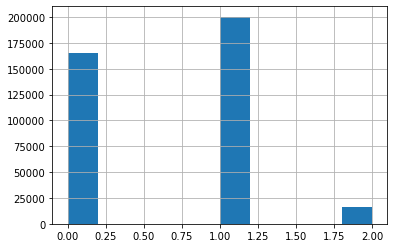

In [12]:
ins_data['Vehicle_Age'].hist()

This shows that most of the vehicles are up to 2 years old, there are not so many vehicles that are older than 2 years. For the analysis, it would be better that we have more options, however we will keep it as it is.

Another thing we will do is to show Annual Premium in EUR as it will be easier to track, currently the data is in Indian Rupees. To do this, we will multiply the data point with 0.011.

In [15]:
ins_data['Annual_Premium_Eur'] = ins_data['Annual_Premium'] * 0.011

In [16]:
ins_data.head()

,id,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_Eur
0,1,0,44,28.0,0,2,1,40454.0,26.0,217,1,444.994
1,2,0,76,3.0,0,1,0,33536.0,26.0,183,0,368.896
2,3,0,47,28.0,0,2,1,38294.0,26.0,27,1,421.234
3,4,0,21,11.0,1,0,0,28619.0,152.0,203,0,314.809
4,5,1,29,41.0,1,0,0,27496.0,152.0,39,0,302.456


In [17]:
ins_data.drop(columns='Annual_Premium', inplace=True)

There are two additional columns that are not needed for the modelling of annual premium. Those are Vintage and Response columns which we will exclude now from the data set.

In [18]:
ins_data.drop(columns=['Vintage', 'Response'], inplace=True)
ins_data.head()

,id,Gender,Age,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Policy_Sales_Channel,Annual_Premium_Eur
0,1,0,44,28.0,0,2,1,26.0,444.994
1,2,0,76,3.0,0,1,0,26.0,368.896
2,3,0,47,28.0,0,2,1,26.0,421.234
3,4,0,21,11.0,1,0,0,152.0,314.809
4,5,1,29,41.0,1,0,0,152.0,302.456


Let's see how are region codes distributed and what are the most common regions in the data set. We can check both histogram and bar chart to observe the frequency.

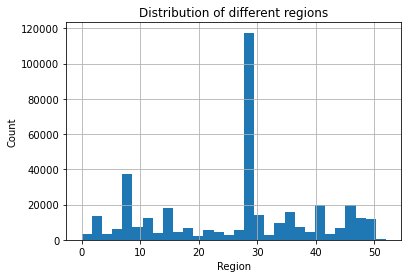

In [19]:
ins_data.Region_Code.hist(bins=30)
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Distribution of different regions');

<AxesSubplot:xlabel='Region', ylabel='Count'>

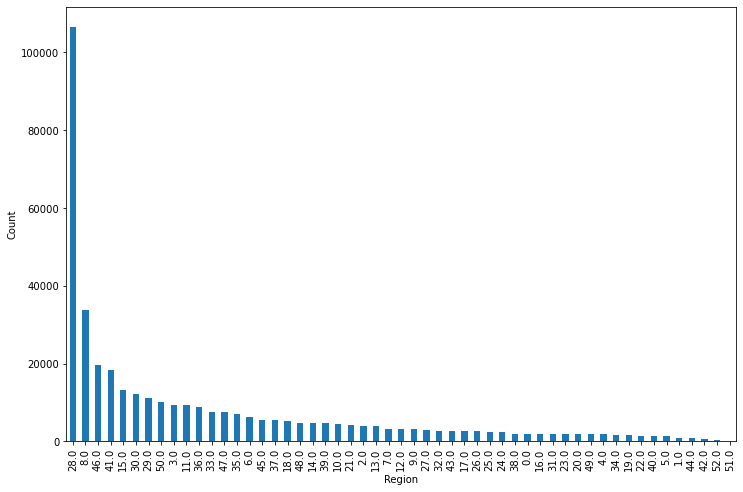

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8))
ins_data.Region_Code.value_counts().plot(kind="bar", xlabel='Region', ylabel='Count')

It is clear that by far the region with the code 28.0 is the most present in the data set, the rest are quite behind which can indicate that this is some metropolitan area densely populated.

The one feature which is not easily readable is Policy Sales Channel, so let us see what kind of options this feature has and how are they distributed.

In [27]:
ins_data['Policy_Sales_Channel'].describe()

count    381109.000000
mean        112.034295
std          54.203995
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

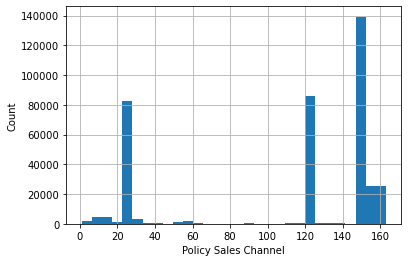

In [28]:
ins_data.Policy_Sales_Channel.hist(bins=30)
plt.xlabel('Policy Sales Channel')
plt.ylabel('Count');

We assume these are the sales channel IDs, however there is no more explanation beyond that, so it very difficult to read the results. The obvious question needed to be asked here is whether this data is useful and what can be done with it.

SAVE THE DATA
In order not to overwrite the previous data set, we will save this data under the new name.

In [30]:
datapath = 'C:/Users/User/Desktop/Data Science Course/Capstone 2'
save_file(ins_data, 'ins_data.csv', datapath)

NameError: name 'save_file' is not defined